In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised=True, split=['train'], shuffle_files=True )


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir=PosixGPath('/tmp/tmpnlkdec9ttfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},


In [ ]:
print(dataset)

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]


In [ ]:
len(dataset[0])

27558

In [ ]:
def split(dataset, train_size, val_size, test_size):
    dataset_size = len(dataset)
    train_dataset = dataset.take(int(train_size * dataset_size))

    val_dataset = dataset.skip(int(train_size * dataset_size)).take(int(val_size * dataset_size))
    test_dataset = dataset.skip(int((train_size + val_size) * dataset_size)).take(int(test_size * dataset_size))

    return train_dataset, val_dataset, test_dataset

In [ ]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

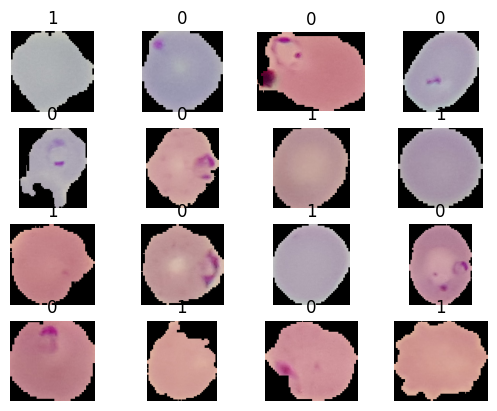

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
def resize_rescale(image, label):
    image = tf.image.resize(image, (224, 224))/255.0
    return image, label

train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 200, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 200, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(224, 224, 3)),
    Conv2D(filters=6, kernel_size=3, padding='valid', strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides=1),

    Conv2D(filters=16, kernel_size=3, padding='valid', strides=1, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = 2, strides=1),

    Flatten(),
    Dense(units=100, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units=20, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(units=1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 221, 221, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 219, 219, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 219, 219, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 218, 218, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 760384)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │      76,038,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 20)                  │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,042,157 (290.08 MB)

 Trainable params: 76,041,873 (290.08 MB)

 Non-trainable params: 284 (1.11 KB)

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.callbacks import EarlyStopping, Callback
import seaborn as sns
metrics = [BinaryAccuracy(), Precision(), Recall(), AUC(), TruePositives(name='tp'), TrueNegatives(name='tn'), FalsePositives(name='fp'), FalseNegatives(name='fn')]




In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Loss: {logs['loss']}")

es_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False, min_delta=0, mode='auto', verbose=1)

def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

In [ ]:
train = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=[LossCallback(), es_callback, plateau_callback] )

Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - auc: 0.7089 - binary_accuracy: 0.6562 - fn: 1599.4934 - fp: 1781.8593 - loss: 0.6336 - precision: 0.6547 - recall: 0.6736 - tn: 3728.2366 - tp: 3930.4080Loss: 0.5221678018569946
689/689 ━━━━━━━━━━━━━━━━━━━━ 88s 107ms/step - auc: 0.7090 - binary_accuracy: 0.6563 - fn: 1600.8724 - fp: 1783.5420 - loss: 0.6335 - precision: 0.6548 - recall: 0.6737 - tn: 3734.5435 - tp: 3936.9897 - val_auc: 0.9463 - val_binary_accuracy: 0.9060 - val_fn: 79.0000 - val_fp: 180.0000 - val_loss: 0.3269 - val_precision: 0.8791 - val_recall: 0.9431 - val_tn: 1187.0000 - val_tp: 1309.0000
Epoch 2/5
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - auc: 0.9262 - binary_accuracy: 0.8774 - fn: 574.9840 - fp: 768.6613 - loss: 0.3462 - precision: 0.8664 - recall: 0.8942 - tn: 4734.8867 - tp: 4945.4683Loss: 0.3380856513977051
689/689 ━━━━━━━━━━━━━━━━━━━━ 60s 86ms/step - auc: 0.9262 - binary_accuracy: 0.8774 - fn: 576.5696 - fp: 770.7696 - loss: 0.3462 - precision: 0.8665 -

In [ ]:
labels = []
inp = []
for x, y in test_dataset:
    labels.append(y.numpy())
    inp.append(x.numpy())

In [ ]:
print(np.array(inp).shape)

(2755, 224, 224, 3)


In [ ]:
print(labels)

[0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 

In [ ]:
predicted = model.predict(np.array(inp))
print(predicted[:, 0])

87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
[0.03504071 0.01333131 0.95281297 ... 0.30837014 0.32288948 0.9407227 ]


In [ ]:
threshold = 0.5
cm = confusion_matrix(labels, predicted > threshold)
print(cm)

[[1312   80]
 [  91 1272]]


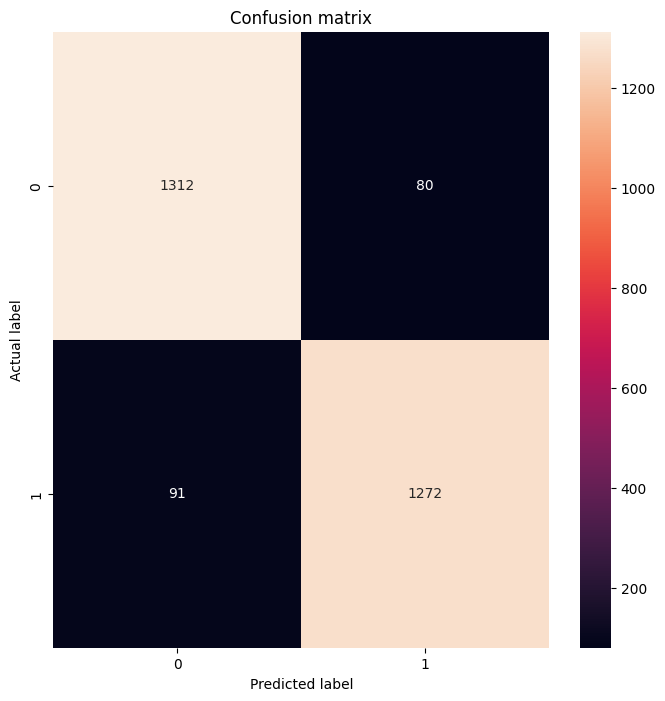

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

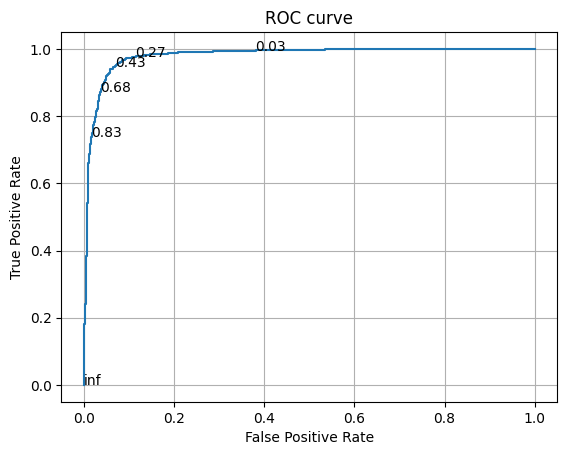

In [ ]:
fp, tp, thresholds= roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
skip = 50
for i in range (0, len(thresholds), skip):
  plt.text(fp[i], tp[i], f'{thresholds[i]:.2f}')
plt.show()

In [ ]:
train.history

{'accuracy': [0.5929874181747437,
  0.6451963782310486,
  0.6579878330230713,
  0.6586682200431824,
  0.6766306757926941,
  0.690782904624939,
  0.6879252195358276,
  0.686881959438324,
  0.7000816464424133,
  0.7307447791099548,
  0.7673500776290894,
  0.8375669121742249,
  0.8714052438735962,
  0.876440167427063,
  0.8922706842422485,
  0.9052435755729675,
  0.9042003154754639,
  0.7345550060272217,
  0.6566270589828491,
  0.6606640815734863,
  0.6489158868789673,
  0.8313072919845581,
  0.8878254294395447,
  0.8963077068328857,
  0.9037920832633972,
  0.9087362885475159,
  0.9196679592132568,
  0.9266533851623535,
  0.9316883087158203,
  0.9315975904464722],
 'loss': [0.6964090466499329,
  0.6318531036376953,
  0.6236573457717896,
  0.6215065717697144,
  0.6077349781990051,
  0.5918792486190796,
  0.5920472741127014,
  0.5985713601112366,
  0.5797654986381531,
  0.5466494560241699,
  0.4994293749332428,
  0.39352765679359436,
  0.3271525204181671,
  0.3264508843421936,
  0.290340662

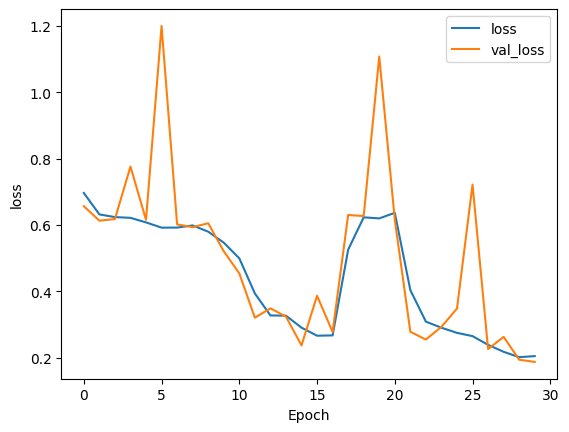

In [ ]:
plt.plot(train.history['loss'], label='loss')
plt.plot(train.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')

plt.legend()
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

2755/2755 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9301 - loss: 0.2090


[0.2014835923910141, 0.9328493475914001]

In [ ]:
ans = model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [ ]:
if(ans > 0.5):
    print("Parasitized")
else:
    print("Uninfected")

Uninfected


In [ ]:
model.save('malaria_model.h5')